### NBDC Coastal Buoy Analysis Helper Functions

In [1]:
import os, re, io, gzip, requests
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import norm
import folium
import fiona

#lucas cartopy
import matplotlib as mpl
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Cannot find header.dxf (GDAL_DATA is not defined)


In [22]:

BASE = "https://www.ndbc.noaa.gov/data/historical/stdmet/"

def list_station_files(station_id: str):
    "noaa scraper that returns .gz files"
    r = requests.get(BASE)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")
    urls = []
    for a in soup.find_all("a", href=True):
        h = a["href"]
        if h.startswith(f"{station_id}h") and h.endswith(".txt.gz"):
            urls.append(urljoin(BASE, h))
    return sorted(urls)

def fetch_file(url, cache_dir="cache"):
    "downloaded once and can be reused from cache"
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, os.path.basename(url))
    if not os.path.exists(fname):
        r = requests.get(url)
        r.raise_for_status()
        with open(fname, "wb") as f:
            f.write(r.content)
    return fname

def read_stdmet(url):
    "atmp data from noaa that returns (atmp, year) if not returns none"
    m = re.search(r"(\d{4})\.txt\.gz", url)
    if not m:
        return None
    year = int(m.group(1))

    fname = fetch_file(url)
    with gzip.open(fname, "rt", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header = None
    for ln in reversed(lines):
        if ln.startswith("#"):
            toks = ln.lstrip("#").strip().split()
            if "MM" in toks and "DD" in toks:
                header = toks
                break
    if not header or "ATMP" not in [h.upper() for h in header]:
        return None

    colnames = [c.lstrip("#").upper() for c in header]

    #de-duplicating names
    seen, unique_cols = {}, []
    for c in colnames:
        if c in seen:
            seen[c] += 1
            c = f"{c}_{seen[c]}"
        else:
            seen[c] = 0
        unique_cols.append(c)

    df = pd.read_csv(
        io.StringIO("".join(lines)),
        sep=r"\s+",
        comment="#",
        header=None,
        names=unique_cols,
        usecols=lambda c: c == "ATMP",
        na_values=["MM", "MM.MM", "99.0", "999.0", "9999.0"],
        engine="python",
    )

    if df["ATMP"].dropna().empty:
        return None

    return year, float(df["ATMP"].max())

def collect_station_max(station, workers=6):
    "process all files for a station in parallel, return series of annual maxima."
    urls = list_station_files(station)
    print(f"Found {len(urls)} files for station {station}")
    annual = {}
    with ThreadPoolExecutor(max_workers=workers) as ex:
        for res in ex.map(read_stdmet, urls):
            if res is None:
                continue
            yr, val = res
            annual[yr] = val
    return pd.Series(annual).sort_index()

def extract_lat_lon(text):
    # in the format of "37.356 N 122.881 W" or "28.508 N 80.185 W"
    m = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*([NS])\s+([0-9]+(?:\.[0-9]+)?)\s*([EW])', text, re.I)
    if m:
        lat = float(m.group(1)) * (1 if m.group(2).upper() == 'N' else -1)
        lon = float(m.group(3)) * (1 if m.group(4).upper() == 'E' else -1)
        return lat, lon
    # optional fallback if a page ever uses "Lat:"/"Lon:" with signed decimals
    m2 = re.search(r'Lat:\s*([-+]?\d+(?:\.\d+)?)\D+Lon:\s*([-+]?\d+(?:\.\d+)?)', text, re.I)
    if m2:
        return float(m2.group(1)), float(m2.group(2))
    return None, None


### Cleaning NBDC Data by Lat/Lon for State Seperation

In [25]:
table_url = "https://www.ndbc.noaa.gov/data/stations/station_table.txt"
txt = requests.get(table_url).text

rows = []
for line in txt.splitlines():
    if '|' not in line:
        continue
    station = line.split('|', 1)[0].strip()
    m = re.search(r'([0-9.]+)\s*([NS])\s+([0-9.]+)\s*([EW])', line)
    if not m:
        continue
    lat = float(m.group(1)) * (1 if m.group(2) == 'N' else -1)
    lon = float(m.group(3)) * (1 if m.group(4) == 'E' else -1)
    rows.append((station, lat, lon))

coords_df = pd.DataFrame(rows, columns=["station", "lat", "lon"])


In [26]:
stdmet_url = "https://www.ndbc.noaa.gov/data/historical/stdmet/"
soup = BeautifulSoup(requests.get(stdmet_url).text, "html.parser")

years = {}
for a in soup.find_all("a", href=True):
    h = a["href"]
    m = re.match(r"(\w+)h(\d{4})\.txt\.gz$", h)
    if m:
        st, yr = m.groups()
        years.setdefault(st, set()).add(int(yr))

years_df = pd.DataFrame(
    [(st, len(yrs)) for st, yrs in years.items()],
    columns=["station", "years_logged"]
)

df = coords_df.merge(years_df, on="station", how="left").fillna({"years_logged": 0})
df

,station,lat,lon,years_logged
0,0y2w3,44.794,-87.313,4.0
1,13001,12.000,-23.000,0.0
2,13002,21.000,-23.000,0.0
3,13008,15.000,-38.000,0.0
4,13009,8.000,-38.000,0.0
...,...,...,...,...
1895,ygnn6,43.262,-79.064,16.0
1896,ykrv2,37.251,-76.342,18.0
1897,yktv2,37.227,-76.479,20.0
1898,yrsv2,37.414,-76.712,0.0


In [27]:
df = df.sort_values(by = 'years_logged', ascending = False).reset_index(drop = True)
#df = pd.DataFrame(data).loc[(lambda d: (d['lat'] > 10 ) & (d['lon'] < 10))]
#df = df.sort_values("years_logged", ascending = False).reset_index(drop = True)
df

,station,lat,lon,years_logged
0,46001,56.296,-148.027,53.0
1,42002,25.950,-93.780,52.0
2,41002,31.743,-74.955,50.0
3,42001,25.926,-89.662,50.0
4,46002,42.662,-130.507,47.0
...,...,...,...,...
1895,62090,53.127,-11.200,0.0
1896,62091,53.469,-5.418,0.0
1897,62092,51.130,-10.330,0.0
1898,62093,55.000,-10.000,0.0


In [28]:
#filter for west coast buoy stations
west_coast = df[
    (df["lat"] >= 32) & (df["lat"] <= 49) & 
    (df["lon"] <= -117) & (df["lon"] >= -125)
]
#now by longest data record
west_coast_sorted = west_coast.sort_values("years_logged", ascending=False).reset_index(drop=True)

print(west_coast_sorted.head(10))

  station     lat      lon  years_logged
0   46012  37.356 -122.881          44.0
1   46014  39.225 -123.980          44.0
2   46013  38.235 -123.317          44.0
3   46011  34.937 -120.999          44.0
4   46025  33.755 -119.045          43.0
5   46026  37.750 -122.838          43.0
6   46022  40.716 -124.540          43.0
7   46027  41.840 -124.382          42.0
8   46028  35.770 -121.903          42.0
9   desw1  47.675 -124.485          41.0


In [29]:
#filter by west coast state 
def classify_state(lat, lon):
    if 42 <= lat <= 49 and -125 <= lon <= -122:
        return "WA/OR"
    elif 32 <= lat < 42 and -125 <= lon <= -117:
        return "CA"
    elif 40 <= lat <= 45 and -125 <= lon <= -120:
        return "OR"
    elif 46 <= lat <= 49 and -125 <= lon <= -120:
        return "WA"
    else:
        return "Other"

df.loc[:,["state"]] = df.apply(lambda r: classify_state(r["lat"], r["lon"]), axis=1)
df


,station,lat,lon,years_logged,state
0,46001,56.296,-148.027,53.0,Other
1,42002,25.950,-93.780,52.0,Other
2,41002,31.743,-74.955,50.0,Other
3,42001,25.926,-89.662,50.0,Other
4,46002,42.662,-130.507,47.0,Other
...,...,...,...,...,...
1895,62090,53.127,-11.200,0.0,Other
1896,62091,53.469,-5.418,0.0,Other
1897,62092,51.130,-10.330,0.0,Other
1898,62093,55.000,-10.000,0.0,Other


In [30]:
df_ca = df[df['state'] == 'CA']
df_ca

,station,lat,lon,years_logged,state
18,46012,37.356,-122.881,44.0,CA
19,46014,39.225,-123.980,44.0,CA
20,46013,38.235,-123.317,44.0,CA
21,46011,34.937,-120.999,44.0,CA
22,46025,33.755,-119.045,43.0,CA
...,...,...,...,...,...
1744,erkc1,40.778,-124.196,0.0,CA
1745,evmc1,36.811,-121.779,0.0,CA
1746,fffc1,38.195,-122.033,0.0,CA
1759,gggc1,38.016,-122.509,0.0,CA


In [31]:
df_waor = df[df['state'] == 'WA/OR']
df_waor

,station,lat,lon,years_logged,state
34,desw1,47.675,-124.485,41.0,WA/OR
42,sisw1,48.321,-122.831,41.0,WA/OR
45,wpow1,47.662,-122.435,41.0,WA/OR
51,nwpo3,44.613,-124.067,40.0,WA/OR
65,46029,46.163,-124.487,38.0,WA/OR
...,...,...,...,...,...
1648,cwqo3,43.338,-124.321,0.0,WA/OR
1716,jtaw1,46.266,-124.038,0.0,WA/OR
1737,hmno3,46.203,-123.952,0.0,WA/OR
1762,gptw1,46.273,-123.767,0.0,WA/OR


### Visualizing Length of Buoy Data through the Cartopy Research Method

In [65]:
def plotting(X, Y, Z, region=[-150, -110, 20, 55], cmap='coolwarm', midpoint=None, vmin=None, vmax=None):
    
    class MidpointNormalize(colors.Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            super().__init__(vmin, vmax, clip)
        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))

    vmin = np.min(Z) if vmin is None else vmin
    vmax = np.max(Z) if vmax is None else vmax
    midpoint = (vmin + vmax)/2 if midpoint is None else midpoint

    fig = plt.figure(figsize=(10,6))
    proj = ccrs.Robinson()
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    sc = ax.scatter(
        X, Y, c=Z,
        cmap=cmap,
        norm=MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint),
        transform=ccrs.PlateCarree(),
        s=40, edgecolor='k', linewidth=0.3
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_extent(region, crs=ccrs.PlateCarree())

    #additional colorbar
    cbar = plt.colorbar(sc, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label("Years Logged")

    plt.title("NOAA Coastal Buoy Data Aggregation")
    plt.show()


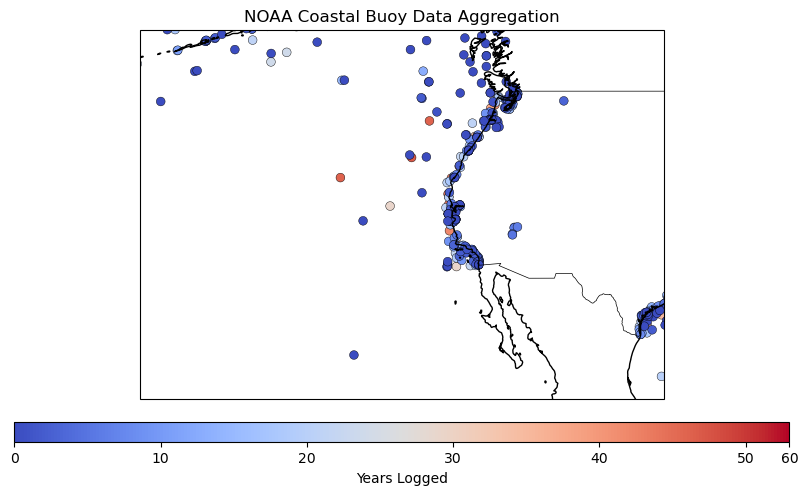

In [74]:
X = df['lon']
Y = df['lat']
Z = df['years_logged']

plotting(X,Y,Z, region = [-150, -110, 20 , 55])

### Visualizing the Buoy Stations by State

In [54]:
#unzipping the kmz file from google earth because previous parsing was heinous

import zipfile

kmz_path = "Marine Obs by Program.kmz"  # your uploaded file
kml_path = "Marine_Obs_by_Program.kml"

# Extract KML from KMZ
with zipfile.ZipFile(kmz_path, "r") as z:
    for name in z.namelist():
        if name.endswith(".kml"):
            z.extract(name, ".")
            kml_path = name
            print(f"Extracted: {kml_path}")


Extracted: doc.kml


In [55]:
import zipfile

with zipfile.ZipFile(kmz_path, "r") as z:
    for name in z.namelist():
        print(" -", name)

    #kml file finding
    kml_files = [n for n in z.namelist() if n.endswith(".kml")]
    if not kml_files:
        print("\n❌ No .kml file found inside the KMZ.")
    else:
        kml_name = kml_files[0]
        print(f"\n✅ Found KML file: {kml_name}")

        # extraction
        with z.open(kml_name) as f:
            kml_content = f.read().decode("utf-8", errors="ignore")

        # placemarks
        soup = BeautifulSoup(kml_content, "xml")
        placemarks = soup.find_all("Placemark")

        print(f"🛰️ Number of <Placemark> entries: {len(placemarks)}")

        # network linking if available?
        netlinks = soup.find_all("NetworkLink")
        if netlinks:
            print(f"🔗 Found {len(netlinks)} <NetworkLink> elements — this file likely references other KMLs.")
        else:
            print("✅ No <NetworkLink> tags — data is self-contained.")

 - doc.kml

✅ Found KML file: doc.kml
🛰️ Number of <Placemark> entries: 1939
✅ No <NetworkLink> tags — data is self-contained.


In [56]:
kmz_path = "Marine Obs by Program.kmz"

with zipfile.ZipFile(kmz_path, "r") as z:
    kml_name = next((n for n in z.namelist() if n.endswith(".kml")), None)
    if not kml_name:
        raise FileNotFoundError("❌ No .kml file found inside the KMZ.")
    print(f"✅ Found KML file: {kml_name}")

    with z.open(kml_name) as f:
        kml_content = f.read().decode("utf-8", errors="ignore")

# parsing kml w beautsoup
soup = BeautifulSoup(kml_content, "xml")
placemarks = soup.find_all("Placemark")
print(f"🛰️ Found {len(placemarks)} Placemark entries.")

stations = []

for pm in placemarks:
    name = pm.find("name").text if pm.find("name") else "Unknown"
    coord_tag = pm.find("coordinates")
    if coord_tag:
        # Coordinates are in format: lon,lat,alt (alt optional)
        coords = coord_tag.text.strip().split(",")
        if len(coords) >= 2:
            lon, lat = float(coords[0]), float(coords[1])
            stations.append({"station": name, "lat": lat, "lon": lon})

df = pd.DataFrame(stations)
print(f"✅ Extracted {len(df)} stations into DataFrame.")
print(df.head())

✅ Found KML file: doc.kml
🛰️ Found 1939 Placemark entries.
✅ Extracted 1939 stations into DataFrame.
  station   lat   lon
0   13001  12.0 -23.0
1   13002  21.0 -23.0
2   13008  15.0 -38.0
3   13009   8.0 -38.0
4   14041  -8.0  55.0


In [57]:
m = folium.Map(location=[38, -122], zoom_start=5, tiles="cartodbpositron")

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7,
        popup=f"Station: {row['station']}"
    ).add_to(m)

#title
title_html = """
<h4 align="center" style="font-size:16px"><b>NOAA Marine Observations — KMZ Station Map</b></h4>
"""
m.get_root().html.add_child(folium.Element(title_html))

# can be saved if we want
output_file = "marine_obs_bysoup.html"
m.save(output_file)
print(f"✅ Map saved as {output_file} — open in your browser.")
m

✅ Map saved as marine_obs_bysoup.html — open in your browser.


In [58]:
kmz_path = "Marine Obs by Program.kmz"

with zipfile.ZipFile(kmz_path, "r") as z:
    kml_name = next((n for n in z.namelist() if n.endswith(".kml")), None)
    if not kml_name:
        raise FileNotFoundError("❌ No .kml file found inside the KMZ.")
    print(f"✅ Found KML file: {kml_name}")

    # Read KML content
    with z.open(kml_name) as f:
        kml_content = f.read().decode("utf-8", errors="ignore")

#beautiful soup parsing
soup = BeautifulSoup(kml_content, "xml")
placemarks = soup.find_all("Placemark")
print(f" {len(placemarks)} Placemark entries.")

stations = []

#station name, coords, program
def get_parent_folder_name(tag):
    """Traverse up the XML tree to find the parent folder name."""
    parent = tag.parent
    while parent:
        if parent.name == "Folder":
            name_tag = parent.find("name")
            if name_tag and name_tag.text.strip():
                return name_tag.text.strip()
        parent = parent.parent
    return "Unknown Program"

for pm in placemarks:
    name = pm.find("name").text.strip() if pm.find("name") else "Unknown"
    coord_tag = pm.find("coordinates")
    if coord_tag:
        coords = coord_tag.text.strip().split(",")
        if len(coords) >= 2:
            lon, lat = float(coords[0]), float(coords[1])
            program = get_parent_folder_name(pm)
            stations.append({
                "station": name,
                "lat": lat,
                "lon": lon,
                "program": program
            })

df = pd.DataFrame(stations)
print(df.head())

#west coast filter
# Approximate bounding box: lat 30–50, lon -130 to -115
west_coast_df = df[(df["lon"] < -115) & (df["lon"] > -130) & (df["lat"] > 30) & (df["lat"] < 50)]
print(f" Filtered to {len(west_coast_df)} West Coast stations.")

#programs by color
unique_programs = west_coast_df["program"].unique()
color_palette = [
    "red", "blue", "green", "orange", "purple", "darkred",
    "cadetblue", "darkgreen", "gray", "black", "pink"
]
color_map = {prog: color_palette[i % len(color_palette)] for i, prog in enumerate(unique_programs)}

#folium
m = folium.Map(
    location=[38, -122],
    zoom_start=5,
    tiles="cartodbpositron",
    max_bounds=True
)
m.fit_bounds([[30, -130], [50, -115]])

for _, row in west_coast_df.iterrows():
    color = color_map.get(row["program"], "gray")
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=folium.Popup(
            f"<b>Station:</b> {row['station']}<br>"
            f"<b>Program:</b> {row['program']}<br>"
            f"<b>Lat:</b> {row['lat']:.2f}, <b>Lon:</b> {row['lon']:.2f}",
            max_width=300
        )
    ).add_to(m)

legend_html = """
<div style="
    position: fixed; 
    bottom: 30px; left: 30px; width: 180px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    font-size:14px; padding: 10px;">
<b>Program Legend</b><br>
"""
for prog, color in color_map.items():
    legend_html += f'<i style="background:{color};width:10px;height:10px;float:left;margin-right:5px;"></i>{prog}<br>'
legend_html += "</div>"

m.get_root().html.add_child(folium.Element(legend_html))

title_html = """
<h4 align="center" style="font-size:16px"><b>NOAA Marine Observations — West Coast Stations by Program</b></h4>
"""
m.get_root().html.add_child(folium.Element(title_html))

#saving
output_file = "marine_obs_westcoast.html"
m.save(output_file)
m


✅ Found KML file: doc.kml
 1939 Placemark entries.
  station   lat   lon                 program
0   13001  12.0 -23.0  International Partners
1   13002  21.0 -23.0  International Partners
2   13008  15.0 -38.0  International Partners
3   13009   8.0 -38.0  International Partners
4   14041  -8.0  55.0  International Partners
 Filtered to 224 West Coast stations.
